In [445]:
##
## Import Dependencies
##

import pandas as pd                                    # Helps preprocess data
from xgboost import XGBClassifier                      # XGBoost: machine learning algorithm (decision tree based)
from sklearn.linear_model import LogisticRegression    # LR: machine learning algorithm (categorical, S shaped)
from sklearn.ensemble import RandomForestClassifier    # RF: machine learning algorithm (decision tree based)
from sklearn.svm import SVC                            # Support Vector Machine: machine learning algorithm (threshold)
import seaborn as sns                                  # Displays data
from time import time                                  # Measure of training time
from sklearn.model_selection import cross_val_score    # Cross validation
from sklearn.metrics import accuracy_score             # Checking accuracy
from time import time                                  # Timer
from sklearn.model_selection import GridSearchCV       # Perfroms grid search to help optimize models
import numpy as np                                     # Used for logspace
import pickle                                          # Export model
%matplotlib inline

In [446]:
# Loads data

data = pd.read_csv('20_21.csv')

In [447]:
# Display categories

data.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH',
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object', length=106)

In [448]:
# Display the whole table

data

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,1.84,0.75,2.01,1.89,2.02,1.91,2.13,1.92,2.02,1.87
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1.70,0.25,1.78,2.13,1.79,2.17,1.85,2.18,1.79,2.12
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,2.62,-1.50,1.85,2.05,1.85,2.08,1.90,2.16,1.84,2.04
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,1.92,-0.50,2.03,1.87,2.04,1.88,2.09,1.91,2.02,1.86
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,1.73,0.25,1.92,1.98,1.93,1.99,1.95,2.01,1.91,1.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,E0,24/04/2021,17:30,West Ham,Chelsea,0,1,A,0,1,...,1.88,0.75,1.99,1.94,1.98,1.94,2.08,1.95,1.99,1.90
323,E0,24/04/2021,20:00,Sheffield United,Brighton,1,0,H,1,0,...,1.71,1.00,1.82,2.11,1.83,2.12,1.87,2.13,1.83,2.05
324,E0,25/04/2021,12:00,Wolves,Burnley,0,4,A,0,3,...,1.57,-0.25,2.05,1.88,2.05,1.88,2.08,1.98,2.02,1.87
325,E0,25/04/2021,14:00,Leeds,Man United,0,0,D,0,0,...,2.05,0.75,1.84,2.09,1.86,2.07,1.96,2.12,1.86,2.04


In [449]:
# Filtering data

# sliced out betting odds, only leaving match statistics
data_20 = data.iloc[:,:23]

# drops out irrelevant data
data_20 = data_20.drop(['Div', 'Date', 'Time', 'Referee'], axis=1)

In [450]:
# Checking if filtering worked

data_20

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR
0,Fulham,Arsenal,0,3,A,0,1,A,5,13,2,6,12,12,2,3,2,2,0
1,Crystal Palace,Southampton,1,0,H,1,0,H,5,9,3,5,14,11,7,3,2,1,0
2,Liverpool,Leeds,4,3,H,3,2,H,22,6,6,3,9,6,9,0,1,0,0
3,West Ham,Newcastle,0,2,A,0,0,D,15,15,3,2,13,7,8,7,2,2,0
4,West Brom,Leicester,0,3,A,0,0,D,7,13,1,7,12,9,2,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,West Ham,Chelsea,0,1,A,0,1,A,9,17,2,6,9,11,4,2,0,4,1
323,Sheffield United,Brighton,1,0,H,1,0,H,7,17,3,4,13,7,2,12,3,0,0
324,Wolves,Burnley,0,4,A,0,3,A,12,14,2,7,8,9,8,5,1,2,0
325,Leeds,Man United,0,0,D,0,0,D,6,16,3,4,21,11,2,6,4,1,0


In [451]:
# Create a new table
#       Team, Home Goals Scored, Away Goals Score, Attack Power, Home Goals Conceded, Away Goals Conceded, Defense Power
#       Home shots, Away shots, Home shot power, Away shot power

table_20 = pd.DataFrame(columns=('Team','HGS','AGS','HAP','AAP','HGC','AGC','HDP','ADP','HS','AS','HSP','ASP', \
                                 'HST','AST','HSTP','ASTP'))

In [452]:
# Finding average goals 
#       (used for finding attack and defence power)
#       AHS = avg home scored, AAS = avg away scored, AHC = avg home conceded, AAC = avg away conceded
#       AHShots = avg home shots, AAShots = avg away shots, AHST = avg home shot on target, AAST = avg away shot on target

AHS = data_20.FTHG.sum() / data_20.shape[0]
AAS = data_20.FTAG.sum() / data_20.shape[0]
AHC = AAS
AAC = AHS
AHShots = data_20.HS.sum() / data_20.shape[0]
AAShots = data_20.AS.sum() / data_20.shape[0]
AHST = data_20.HST.sum() / data_20.shape[0]
AAST = data_20.AST.sum() / data_20.shape[0]

In [453]:
# Grouping data by teams for home and away (no duplicates)

home = data_20.groupby('HomeTeam')
away = data_20.groupby('AwayTeam')

In [454]:
# Calculating number of games
#        Assumes num of home games = num of away games

num_games = data_20.shape[0]/20

In [455]:
# Listing teams and removing duplicates
teams = data_20.iloc[:,0]
lot = list(teams.sort_values())
lot = list(dict.fromkeys(lot))

# Assigning values to table
table_20.Team = lot

table_20.HGS = home.FTHG.sum().values
table_20.HGC = home.FTAG.sum().values
table_20.AGS = away.FTAG.sum().values
table_20.AGC = away.FTHG.sum().values
table_20.HS = home.HS.sum().values
table_20.AS = away.AS.sum().values
table_20.HST = home.HST.sum().values
table_20.AST = away.AST.sum().values

table_20.HAP = (table_20.HGS / num_games) / AHS
table_20.AAP = (table_20.AGS / num_games) / AAS
table_20.HDP = (table_20.HGC / num_games) / AHC
table_20.ADP = (table_20.AGC / num_games) / AAC
table_20.HSP = (table_20.HS / num_games) / AHShots
table_20.ASP = (table_20.AS / num_games) / AAShots
table_20.HSTP = (table_20.HST / num_games) / AHST
table_20.ASTP = (table_20.AST / num_games) / AAST

In [456]:
# Checking if the table works

table_20

,Team,HGS,AGS,HAP,AAP,HGC,AGC,HDP,ADP,HS,AS,HSP,ASP,HST,AST,HSTP,ASTP
0,Arsenal,19,25,0.873563,1.157407,20,17,0.925926,0.781609,209,189,1.011617,1.045065,65,65,0.884354,0.983359
1,Aston Villa,26,20,1.195402,0.925926,23,14,1.064815,0.643678,239,190,1.156825,1.050594,85,78,1.156463,1.180030
2,Brighton,16,17,0.735632,0.787037,19,20,0.879630,0.919540,249,182,1.205227,1.006359,67,59,0.911565,0.892587
3,Burnley,13,17,0.597701,0.787037,18,27,0.833333,1.241379,163,163,0.788964,0.901299,52,59,0.707483,0.892587
4,Chelsea,27,24,1.241379,1.111111,16,15,0.740741,0.689655,238,240,1.151985,1.327067,96,85,1.306122,1.285930
5,Crystal Palace,16,17,0.735632,0.787037,25,27,1.157407,1.241379,118,146,0.571152,0.807299,42,53,0.571429,0.801815
6,Everton,22,22,1.011494,1.018519,25,15,1.157407,0.689655,172,150,0.832527,0.829417,63,61,0.857143,0.922844
7,Fulham,9,16,0.413793,0.740741,24,19,1.111111,0.873563,199,180,0.963214,0.995300,60,62,0.816327,0.937973
8,Leeds,22,28,1.011494,1.296296,19,31,0.879630,1.425287,232,215,1.122943,1.188831,91,77,1.238095,1.164902
9,Leicester,28,30,1.287356,1.388889,21,16,0.972222,0.735632,196,198,0.948693,1.094830,74,76,1.006803,1.149773


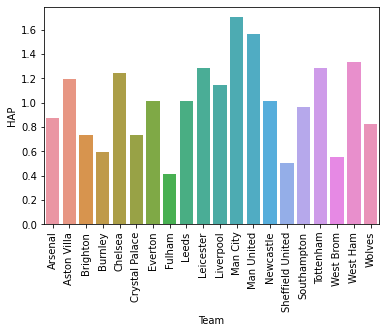

In [457]:
# Plotting Home attacking power

HAP_plot = sns.barplot(x = table_20.Team, y = table_20.HAP)

# Rotates x lables to make it visible
for i in HAP_plot.get_xticklabels():
    i.set_rotation(90)
    
# The higher the better

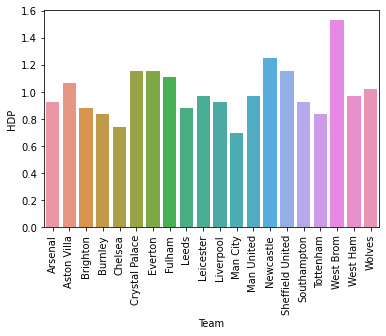

In [458]:
# Plotting Home defending power

HDP_plot = sns.barplot(x = table_20.Team, y = table_20.HDP)

# Rotates x lables to make it visible
for i in HDP_plot.get_xticklabels():
    i.set_rotation(90)
    
# The lower the better

In [459]:
# Function that assigns the powers

def assigner(table, powers):
    HAP = []
    HDP = []
    AAP = []
    ADP = []
    HSP = []
    ASP = []
    HSTP = []
    ASTP = []
    
    for index, row in table.iterrows():
        HAP.append(powers[powers['Team'] == row['HomeTeam']]['HAP'].values[0])
        HDP.append(powers[powers['Team'] == row['HomeTeam']]['HDP'].values[0])
        AAP.append(powers[powers['Team'] == row['AwayTeam']]['AAP'].values[0])
        ADP.append(powers[powers['Team'] == row['AwayTeam']]['ADP'].values[0])
        HSP.append(powers[powers['Team'] == row['HomeTeam']]['HSP'].values[0])
        ASP.append(powers[powers['Team'] == row['AwayTeam']]['ASP'].values[0])
        HSTP.append(powers[powers['Team'] == row['HomeTeam']]['HSTP'].values[0])
        ASTP.append(powers[powers['Team'] == row['AwayTeam']]['ASTP'].values[0])

    table['HAP'] = HAP
    table['HDP'] = HDP
    table['AAP'] = AAP
    table['ADP'] = ADP
    table['HSP'] = HSP
    table['ASP'] = ASP
    table['HSTP'] = HSTP
    table['ASTP'] = ASTP
    

In [460]:
# Creating a feature_table that contains all the fixtures
#         ftr = full time result

feature_table = data_20.iloc[:,:13]
feature_table = feature_table[['HomeTeam','AwayTeam','FTR']]

assigner(feature_table, table_20)

In [461]:
# Checking if table works

feature_table

,HomeTeam,AwayTeam,FTR,HAP,HDP,AAP,ADP,HSP,ASP,HSTP,ASTP
0,Fulham,Arsenal,A,0.413793,1.111111,1.157407,0.781609,0.963214,1.045065,0.816327,0.983359
1,Crystal Palace,Southampton,H,0.735632,1.157407,0.879630,1.747126,0.571152,0.917888,0.571429,0.922844
2,Liverpool,Leeds,H,1.149425,0.925926,1.296296,1.425287,1.374637,1.188831,1.333333,1.164902
3,West Ham,Newcastle,A,1.333333,0.972222,0.648148,1.241379,0.943853,0.779652,1.006803,0.801815
4,West Brom,Leicester,A,0.551724,1.527778,1.388889,0.735632,0.677638,1.094830,0.653061,1.149773
...,...,...,...,...,...,...,...,...,...,...,...
322,West Ham,Chelsea,A,1.333333,0.972222,1.111111,0.689655,0.943853,1.327067,1.006803,1.285930
323,Sheffield United,Brighton,H,0.505747,1.157407,0.787037,0.919540,0.803485,1.006359,0.761905,0.892587
324,Wolves,Burnley,A,0.827586,1.018519,0.787037,1.241379,1.161665,0.901299,1.074830,0.892587
325,Leeds,Man United,D,1.011494,0.879630,1.388889,0.643678,1.122943,1.210948,1.238095,1.422088


In [462]:
# Function to transform FTR to numeric values

def TransformLetters(row):
    '''
    Consumes row, reads FTR of the row, and returns  
    1 if its Home victory, -1 if Away victory, and 0
    if it is draw
    '''
    
    if(row.FTR == 'H'):
        return 1
    elif (row.FTR == 'A'):
        return -1
    elif (row.FTR == 'D'):
        return 0
    
# Actually transforming FTR

feature_table['Result'] = feature_table.apply(lambda x: TransformLetters(x), axis = 1)

In [463]:
# Checking table

feature_table

,HomeTeam,AwayTeam,FTR,HAP,HDP,AAP,ADP,HSP,ASP,HSTP,ASTP,Result
0,Fulham,Arsenal,A,0.413793,1.111111,1.157407,0.781609,0.963214,1.045065,0.816327,0.983359,-1
1,Crystal Palace,Southampton,H,0.735632,1.157407,0.879630,1.747126,0.571152,0.917888,0.571429,0.922844,1
2,Liverpool,Leeds,H,1.149425,0.925926,1.296296,1.425287,1.374637,1.188831,1.333333,1.164902,1
3,West Ham,Newcastle,A,1.333333,0.972222,0.648148,1.241379,0.943853,0.779652,1.006803,0.801815,-1
4,West Brom,Leicester,A,0.551724,1.527778,1.388889,0.735632,0.677638,1.094830,0.653061,1.149773,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
322,West Ham,Chelsea,A,1.333333,0.972222,1.111111,0.689655,0.943853,1.327067,1.006803,1.285930,-1
323,Sheffield United,Brighton,H,0.505747,1.157407,0.787037,0.919540,0.803485,1.006359,0.761905,0.892587,1
324,Wolves,Burnley,A,0.827586,1.018519,0.787037,1.241379,1.161665,0.901299,1.074830,0.892587,-1
325,Leeds,Man United,D,1.011494,0.879630,1.388889,0.643678,1.122943,1.210948,1.238095,1.422088,0


In [464]:
# Splitting data and initializing models

X_train1 = feature_table[['HAP','HDP','AAP','ADP','HSP','ASP','HSTP','ASTP']]
y_train1 = feature_table['Result']

clf1 = LogisticRegression()
clf2 = XGBClassifier(eval_metric='mlogloss')
clf3 = SVC()

In [465]:
# Checking logistic regression accuracy

scores1 = cross_val_score(clf1, X_train1, y_train1, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores1}\n")
print(f"Averages score:\n{scores1.mean()}")

Scores of the 10 splits of test train data:
[0.54545455 0.39393939 0.48484848 0.48484848 0.72727273 0.51515152
 0.48484848 0.5625     0.5625     0.5       ]

Averages score:
0.5261363636363636


In [466]:
# Checking XGBoost classifier accuracy

scores2 = cross_val_score(clf2, X_train1, y_train1, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores2}\n")
print(f"Averages score:\n{scores2.mean()}")

C:\Users\Festa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Festa\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Scores of the 10 splits of test train data:
[0.36363636 0.24242424 0.33333333 0.36363636 0.45454545 0.51515152
 0.51515152 0.4375     0.46875    0.4375    ]

Averages score:
0.41316287878787883


In [467]:
# Checking Support Vector Machine accuracy

scores3 = cross_val_score(clf3, X_train1, y_train1, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores3}\n")
print(f"Averages score:\n{scores3.mean()}")

Scores of the 10 splits of test train data:
[0.54545455 0.45454545 0.48484848 0.48484848 0.6969697  0.45454545
 0.48484848 0.53125    0.5        0.46875   ]

Averages score:
0.5106060606060606


In [468]:
# Adding recent results table

recent_table = data_20.sort_index(ascending = False)
recent_table['Result'] = recent_table.apply(lambda x: transform(x), axis = 1)
recent_table = recent_table[['HomeTeam','AwayTeam','Result']]

recent_table

,HomeTeam,AwayTeam,Result
326,Aston Villa,West Brom,0
325,Leeds,Man United,0
324,Wolves,Burnley,-1
323,Sheffield United,Brighton,1
322,West Ham,Chelsea,-1
...,...,...,...
4,West Brom,Leicester,-1
3,West Ham,Newcastle,-1
2,Liverpool,Leeds,1
1,Crystal Palace,Southampton,1


In [469]:
# Adding Matchday 34 fixtures of 2020/2021 season

new_fixtures = pd.DataFrame([['Southampton','Leicester', 0],
                            ['Crystal Palace','Man City', 0],
                            ['Brighton','Leeds', 0],
                            ['Chelsea','Fulham', 0],
                            ['Everton','Aston Villa', 0],
                            ['Newcastle','Arsenal', 0],
                            ['Man United','Liverpool', 0],
                            ['Tottenham','Sheffield United', 0],
                            ['West Brom','Wolves', 0],
                            ['Burnley','West Ham', 0]])

new_fixtures.columns = ['HomeTeam','AwayTeam','Result']

new_fixtures = new_fixtures.sort_index(ascending=False)

In [470]:
# Checking if new fixture works

new_fixtures

,HomeTeam,AwayTeam,Result
9,Burnley,West Ham,0
8,West Brom,Wolves,0
7,Tottenham,Sheffield United,0
6,Man United,Liverpool,0
5,Newcastle,Arsenal,0
4,Everton,Aston Villa,0
3,Chelsea,Fulham,0
2,Brighton,Leeds,0
1,Crystal Palace,Man City,0
0,Southampton,Leicester,0


In [471]:
# Appending new fixture table to recent table

temp = new_fixtures.append(recent_table, ignore_index=True)
temp = temp.sort_index(ascending=False)
temp = temp.reset_index().drop(['index'],axis=1)
test_table = temp

In [472]:
# Adding recent perfomence measures to the table

test_table['pastHResult'] = 0.0
test_table['pastAResult'] = 0.0

In [473]:
# Checking if recent table works

test_table

,HomeTeam,AwayTeam,Result,pastHResult,pastAResult
0,Fulham,Arsenal,-1,0.0,0.0
1,Crystal Palace,Southampton,1,0.0,0.0
2,Liverpool,Leeds,1,0.0,0.0
3,West Ham,Newcastle,-1,0.0,0.0
4,West Brom,Leicester,-1,0.0,0.0
...,...,...,...,...,...
332,Newcastle,Arsenal,0,0.0,0.0
333,Man United,Liverpool,0,0.0,0.0
334,Tottenham,Sheffield United,0,0.0,0.0
335,West Brom,Wolves,0,0.0,0.0


In [474]:
# Adding K recent performences metrics

def PastPerformences(table):
    k = 4
    for i in range(table.shape[0]-1,-1,-1):
        row = table.loc[i]
        ht = row.HomeTeam
        at = row.AwayTeam

        home_ht = table.loc[table['HomeTeam'] == ht]
        away_ht = table.loc[table['AwayTeam'] == ht]
        all_h_games = home_ht.append(away_ht)
        all_h_games = all_h_games.sort_index(ascending=False)

        home_at = table.loc[table['HomeTeam'] == at]
        away_at = table.loc[table['AwayTeam'] == at]
        all_a_games = home_at.append(away_at)
        all_a_games = all_a_games.sort_index(ascending=False)

        temp_h = all_h_games.loc[i:].iloc[1:].head(k)
        temp_a = all_a_games.loc[i:].iloc[1:].head(k)
        h = len(temp_h)
        a = len(temp_a)

        if h == 0:
            h = 1

        if a == 0:
            a = 1

        table.at[i,'pastHResult'] = (temp_h[temp_h['HomeTeam'] == ht].sum().Result - \
                                     temp_h[temp_h['AwayTeam'] == ht].sum().Result)/h
        table.at[i,'pastAResult'] = (temp_a[temp_a['HomeTeam'] == at].sum().Result - \
                                     temp_a[temp_a['AwayTeam'] == at].sum().Result)/a

start = time()
PastPerformences(test_table)
end = time()

print("Took {:.4f} seconds".format(end-start))

Took 2.4945 seconds


In [475]:
# Adding powers

assigner(test_table, table_20)

In [476]:
# Checking if metrics were added

test_table

,HomeTeam,AwayTeam,Result,pastHResult,pastAResult,HAP,HDP,AAP,ADP,HSP,ASP,HSTP,ASTP
0,Fulham,Arsenal,-1,0.00,0.00,0.413793,1.111111,1.157407,0.781609,0.963214,1.045065,0.816327,0.983359
1,Crystal Palace,Southampton,1,0.00,0.00,0.735632,1.157407,0.879630,1.747126,0.571152,0.917888,0.571429,0.922844
2,Liverpool,Leeds,1,0.00,0.00,1.149425,0.925926,1.296296,1.425287,1.374637,1.188831,1.333333,1.164902
3,West Ham,Newcastle,-1,0.00,0.00,1.333333,0.972222,0.648148,1.241379,0.943853,0.779652,1.006803,0.801815
4,West Brom,Leicester,-1,0.00,0.00,0.551724,1.527778,1.388889,0.735632,0.677638,1.094830,0.653061,1.149773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,Newcastle,Arsenal,0,0.50,-0.25,1.011494,1.250000,1.157407,0.781609,0.968054,1.045065,0.925170,0.983359
333,Man United,Liverpool,0,0.75,0.50,1.563218,0.972222,1.388889,0.873563,1.161665,1.260713,1.319728,1.331316
334,Tottenham,Sheffield United,0,0.00,-0.50,1.287356,0.833333,0.324074,1.425287,0.871249,0.613768,1.020408,0.529501
335,West Brom,Wolves,0,0.25,0.00,0.551724,1.527778,0.648148,1.057471,0.677638,0.818358,0.653061,0.741301


In [477]:
# Splitting data

split = recent_table.shape[0]-len(new_fixtures)

X_train2 = test_table[['HAP','HDP','AAP','ADP','HSP','ASP','HSTP','ASTP','pastAResult','pastHResult']].loc[0:split]
y_train2 = test_table['Result'].loc[0:split]
X_test2 = test_table[['HAP','HDP','AAP','ADP','HSP','ASP','HSTP','ASTP','pastAResult','pastHResult']].loc[split:]
y_test2 = test_table['Result'].loc[split:]

In [478]:
# Checking logistic regression accuracy

scores1 = cross_val_score(clf1, X_train2, y_train2, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores1}\n")
print(f"Averages score:\n{scores1.mean()}")

Scores of the 10 splits of test train data:
[0.5625    0.375     0.5       0.5       0.625     0.53125   0.46875
 0.4375    0.5483871 0.5483871]

Averages score:
0.5096774193548388


In [419]:
# Checking XGBoost classifier accuracy

scores2 = cross_val_score(clf2, X_train2, y_train2, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores2}\n")
print(f"Averages score:\n{scores2.mean()}")

C:\Users\Festa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Festa\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Scores of the 10 splits of test train data:
[0.48484848 0.36363636 0.42424242 0.36363636 0.48484848 0.51515152
 0.51515152 0.63636364 0.5        0.53125   ]

Averages score:
0.4819128787878787


In [420]:
# Checking Support Vector Machine accuracy

scores3 = cross_val_score(clf3, X_train2, y_train2, cv=10)

print(f"Scores of the 10 splits of test train data:\n{scores3}\n")
print(f"Averages score:\n{scores3.mean()}")

Scores of the 10 splits of test train data:
[0.57575758 0.42424242 0.51515152 0.48484848 0.63636364 0.51515152
 0.48484848 0.51515152 0.5625     0.5       ]

Averages score:
0.5214015151515151


In [421]:
# Paramters for grid search

param_log = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
              'max_iter' : [100, 1000,2500, 5000]
            }


param_XGB = {'min_child_weight': [1, 5, 10],
             'gamma': [0.5, 1, 1.5, 2, 5],
             'subsample': [0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'max_depth': [3, 4, 5]
            }

param_SVC = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
             {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [422]:
# Fitting models

logreg_model = LogisticRegression()
XGB_model = XGBClassifier(eval_metric='mlogloss')
SVC_model = SVC()

In [334]:
# Checking tuned logistic regression accuracy

clf_logreg = GridSearchCV(logreg_model, param_grid = param_log, cv=3, verbose=True, n_jobs=-1)
best_logreg = clf_logreg.fit(X_train2, y_train2)
print(f'Accuracy -: {best_logreg.score(X_train2, y_train2):.3f}')

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    5.4s


Accuracy -: 0.540


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   14.6s finished


In [335]:
# Checking tuned XGBoost classifier accuracy

clf_XGB = GridSearchCV(XGB_model, param_grid = param_XGB, cv=3, verbose=True, n_jobs=-1)
best_XGB = clf_XGB.fit(X_train2, y_train2)
print(f'Accuracy -: {best_XGB.score(X_train2, y_train2):.3f}')

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.5min finished
C:\Users\Festa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy -: 0.573


C:\Users\Festa\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [336]:
# Checking tuned Support Vector Machine accuracy

clf_SVC = GridSearchCV(SVC_model, param_grid = param_SVC, cv=3, verbose=True, n_jobs=-1)
best_SVC = clf_SVC.fit(X_train2, y_train2)
print(f'Accuracy -: {best_SVC.score(X_train2, y_train2):.3f}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Accuracy -: 0.540


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.7s finished


In [423]:
# Making predictions

y_pred_logreg = best_logreg.predict(X_test2)
y_pred_XGB = best_XGB.predict(X_test2)
y_pred_SVC = best_SVC.predict(X_test2)

C:\Users\Festa\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [424]:
# Putting predictions into table

week_34 = test_table[['HomeTeam','AwayTeam']].loc[split:]
week_34['Result_logreg'] = y_pred_logreg
week_34['Result_XGB'] = y_pred_XGB
week_34['Result_SVC'] = y_pred_SVC

In [425]:
# Checking result table

week_34

,HomeTeam,AwayTeam,Result_logreg,Result_XGB,Result_SVC
327,Southampton,Leicester,-1,-1,-1
328,Crystal Palace,Man City,-1,-1,-1
329,Brighton,Leeds,-1,-1,-1
330,Chelsea,Fulham,1,1,1
331,Everton,Aston Villa,-1,-1,-1
332,Newcastle,Arsenal,-1,-1,-1
333,Man United,Liverpool,-1,-1,-1
334,Tottenham,Sheffield United,1,1,1
335,West Brom,Wolves,-1,1,1
336,Burnley,West Ham,-1,-1,-1


In [426]:
# Function to transform numeric values to Home, Draw, Away

def transformNumeric(row,col_name):
    if(row[col_name] == 1):
        return 'Home'
    elif(row[col_name] == -1):
        return 'Away'
    else:
        return 'Draw'

In [427]:
# Transforms numeric values of results to home draw and away

week_34["Result Logistic Regression"] = week_34.apply(lambda row: transformNumeric(row,"Result_logreg"),axis=1)
week_34["Result XGBoost"] = week_34.apply(lambda row: transformNumeric(row,"Result_XGB"),axis=1)
week_34["Result Support Vector Machine"] = week_34.apply(lambda row: transformNumeric(row,"Result_SVC"),axis=1)

week_34.drop(["Result_logreg", "Result_XGB","Result_SVC"],axis=1,inplace=True)

In [482]:
# Checking result table

week_34

,HomeTeam,AwayTeam,Result Logistic Regression,Result XGBoost,Result Support Vector Machine
327,Southampton,Leicester,Away,Away,Away
328,Crystal Palace,Man City,Away,Away,Away
329,Brighton,Leeds,Away,Away,Away
330,Chelsea,Fulham,Home,Home,Home
331,Everton,Aston Villa,Away,Away,Away
332,Newcastle,Arsenal,Away,Away,Away
333,Man United,Liverpool,Away,Away,Away
334,Tottenham,Sheffield United,Home,Home,Home
335,West Brom,Wolves,Away,Home,Home
336,Burnley,West Ham,Away,Away,Away


In [481]:
# Exporting models for flask

pickle.dump(best_logreg, open('logreg.pkl','wb'))
pickle.dump(best_XGB, open('xgb.pkl','wb'))
pickle.dump(best_SVC, open('SVC.pkl','wb'))
pickle.dump(table_20, open('power_table.pkl','wb'))
pickle.dump(recent_table, open('recent_table.pkl','wb'))